In [1416]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import inspect
import pickle
from sklearn import linear_model

In [7]:
%matplotlib inline

In [8]:
def auto_init_args(init):
    def new_init(self, *args, **kwargs):
        arg_dict = inspect.signature(init).parameters
        arg_names = list(arg_dict.keys())[1:]  # skip self
        proc_names = set()
        for name, arg in zip(arg_names, args):
            setattr(self, name, arg)
            proc_names.add(name)
        for name, arg in kwargs.items():
            setattr(self, name, arg)
            proc_names.add(name)
        remain_names = set(arg_names) - proc_names
        if len(remain_names):
            for name in remain_names:
                setattr(self, name, arg_dict[name].default)
        init(self, *args, **kwargs)

    return new_init

In [5]:
def qua_lam(lam):
    x = np.arange(-2, 2, 0.01)
    MY = x**2/(2*(1+lam))
    TW = x**2/(2*(1+lam)) + 1/2*np.log(1+lam)
    plt.plot(x, x**2/2, label="original")
    plt.plot(x, MY, label="MY")
    plt.plot(x, TW, label="TW")
    plt.legend()
    plt.grid()
    plt.title("lambda=" + str(lam))

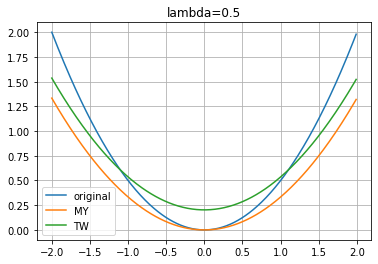

In [49]:
qua_lam(0.5)

In [60]:
def qua_lam():
    x = np.arange(-1.5, 1.5, 0.01)
    plt.plot(x, x**2/2, label="original")
    for lam in [0.1, 0.3, 0.5]:
        TW = x**2/(2*(1+lam)) + 1/2*np.log(1+lam)
        plt.plot(x, TW, label="TW" + str(lam))
    plt.legend()
    plt.grid()
    plt.title("quadratic function")
#     plt.savefig("TW_quadractic.png", bbox_inches="tight")

In [64]:
def fx_linear(x, lam, rho=1):
    return np.exp(rho*x) * (1-norm.cdf((rho*lam+x)/np.sqrt(lam)))

In [106]:
def linear_lam():
    x = np.arange(-1.5, 1.5, 0.01)
    plt.plot(x, np.abs(x), label="original")
    for lam in [0.1, 0.3, 0.5]:
        TW = -np.log(fx_linear(x, lam) + fx_linear(-x, lam)) - (lam/2)
        plt.plot(x, TW, label="TW" + str(lam))
    plt.legend()
    plt.grid()
    plt.title("linear function")
#     plt.savefig("TW_linear.png", bbox_inches="tight")

In [104]:
def penalty_lam(num):
    x = np.arange(-10, 10, 0.01)
    fx = []
    for x_ in x:
        if x_ < num and x_ > -num:
            fx.append(0)
        else:
            fx.append(np.nan)
    plt.xlim((-num*2, num*2))
    plt.ylim((-1, 10))
    plt.plot(x, fx, label="original")
    for lam in [0.1, 0.3, 0.5]:
        TW = -np.log(norm.cdf((x+num)/np.sqrt(lam)) - norm.cdf((x-num)/np.sqrt(lam)))
        plt.plot(x, TW, label="TW" + str(lam))
    plt.legend()
    plt.grid()
    plt.title("Penalty function")
#     plt.savefig("TW_penalty.png", bbox_inches="tight")

/Users/bumeng/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


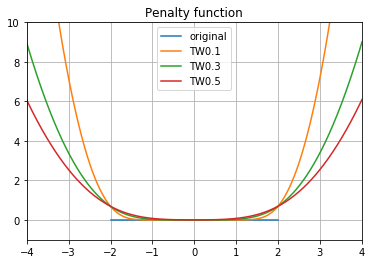

In [105]:
penalty_lam(2)

In [181]:
def horseshoe(x, mu, lam, tau):
    return np.exp(-x**2/(2*(mu+lam)))*((mu+lam)**(-1/2))*(mu**(-1/2))*((1+mu/(tau**2))**(-1))

In [179]:
def horseshoe_lam(tau):
    x = np.arange(-0.1, 0.1, 0.0025)
    fx = []
    for x_ in x:
        ans, _ = quad(lambda u:horseshoe(x_, u, 0, tau), 0, np.infty)
        fx.append(-np.log(ans))
    plt.ylim((-3, 0))
    plt.plot(x, fx, label="original")
    for lam in [0.0001, 0.0003, 0.0005]:
        TW = []
        for x_ in x:
            ans, _ = quad(lambda u:horseshoe(x_, u, lam, tau), 0, np.infty)
            TW.append(-np.log(ans))
        plt.plot(x, TW, label="TW" + str(lam))
    plt.legend()
    plt.grid()
    plt.title("Horseshoe")
    plt.savefig("TW_horseshoe.png", bbox_inches="tight")

/Users/bumeng/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  """


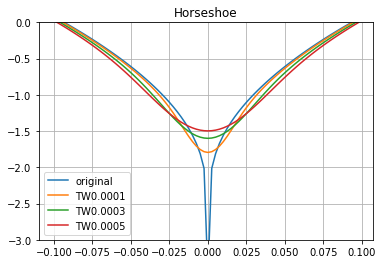

In [180]:
horseshoe_lam(0.1)

In [806]:
def fx(x, a, var, *args, **kwargs):
    return (x-a)**2/(2*var)
def gradf(x, a, var, *args, **kwargs):
    return (x-a)/var

In [816]:
def logdist(x, fx, gx,  *args, **kwargs):
    return -fx(x, *args, **kwargs) - gx(x, *args, **kwargs)

In [882]:
# Laplace
def integration_laplace(rho, a, var, fx=fx, add=0):
    ans, _ = quad(lambda x: np.exp(
        logdist(x=x, fx=fx, gx=gx_laplace, rho=rho, a=a, var=var) + add), -np.infty, np.infty)
    return ans

def gx_laplace(x, rho, *args, **kwargs):
    return rho*np.abs(x)

def postmean_laplace(x, lam, rho, *args, **kwargs):
    A = np.exp(-rho*x)*norm.cdf(np.sqrt(1/lam)*(x-lam*rho)) * 100
    B = np.exp(rho*x)*(1-norm.cdf(np.sqrt(1/lam)*(x+lam*rho))) * 100
    return x - lam*rho*(A-B)/(A+B)

In [883]:
# Horseshoe
def pi_fn(u, tau, *args, **kwargs):
    return u**(-1/2)*(1+u/(tau**2))**(-1)*(tau**(-1))

def gx_horseshoe(x, tau, *args, **kwargs):
    if np.isscalar(x):
        x_list = [x]
    else:
        x_list = x
    e_gx = []
    for x_ in x_list:
        ans, _ = quad(lambda u: np.exp(-x_**2/(2*u))*u**(-1/2)*pi_fn(u, tau=tau), 0, np.infty)
        e_gx.append(ans)
    gx = -np.log(np.array(e_gx))
    if np.isscalar(x):
        return gx[0]
    else:
        return gx
    
def integration_horseshoe(a, var, tau, fx, *args, **kwargs):
    ans, _ = quad(lambda u: (1+u)**(-1/2)*np.exp(-a**2/(2*(u+1)))*pi_fn(u, tau=tau), 0, np.infty)
    return ans*np.sqrt(2*np.pi)

def temp_fn(u, x, lam, tau, *args, **kwargs):
    return (lam+u)**(-3/2)*np.exp(-(x**2)/(2*(u+lam)))*pi_fn(u, tau)

def postmean_horseshoe(x, lam, tau, *args, **kwargs):
    A, _ = quad(lambda u:temp_fn(u, x, lam, tau)*u, 0, np.infty)
    B, _ = quad(lambda u:temp_fn(u, x, lam, tau)*(lam+u), 0, np.infty)
    return A / B * x

In [894]:
# main algorithm
def TDLMC(x0, num_iter, h, lam, fun_postmean, gx, a, var, view_num=2000, *args, **kwargs):
    store, storefun = [], []
    cur_x = np.array(x0)
    dim = len(cur_x)
    for i in range(num_iter):
        xi = np.random.normal(loc=0, scale=1, size=dim)
        post_mean = fun_postmean(cur_x, lam, *args, **kwargs)
        next_x = (1-h/lam)*cur_x - h*gradf(cur_x, a, var) + h/lam*post_mean + np.sqrt(2*h)*xi
        cur_x = next_x
        store.append(cur_x)
        storefun.append(fx(cur_x, a, var) + gx(cur_x, *args, **kwargs))
        if i % view_num == 0:
            print("iteration " + str(i) + " finished!")
    return store, storefun

#### Laplace Experiment

In [853]:
# laplace experiment
rho = 1
lam = 0.05/rho**2
h = lam
num_iter = 60000
a = 2
var = 1
print(lam, h, 1/h)

0.05 0.05 20.0


In [854]:
np.random.seed(19931028)
store, storefun = TDLMC(
    x0=[2], num_iter=num_iter, 
    rho=rho, h=h, lam=lam, 
    a=2, var=1, fun_postmean=postmean_laplace, gx=gx_laplace)

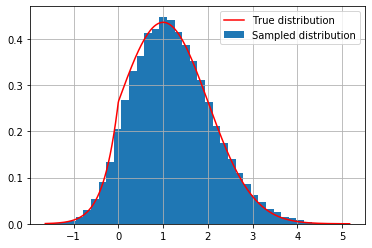

In [855]:
plt.grid(True)
sample_data = np.concatenate(store)
_ = plt.hist(sample_data, bins=40, density=True, label="Sampled distribution")
grid_x = np.arange(min(sample_data), max(sample_data), 0.01)
grid_y = np.exp(logdist(
    x=grid_x, fx=fx, gx=gx, rho=rho, a=a, var=var) + 1
    ) / integration_laplace(rho, a, var, add=1)
plt.plot(grid_x, grid_y, color="red", label="True distribution")
plt.legend()
# plt.savefig("TW_laplace_sampled_1d_rho1.png", bbox_inches="tight")

#### Horseshoe Experiment

In [398]:
# horseshoe experiment
tau = 0.1
lam = 0.01 * np.sqrt(tau)
h = lam
num_iter = 60000
a = 2
var = 1
print(lam, h, 1/h)

0.0031622776601683794 0.0031622776601683794 316.2277660168379


In [977]:
np.random.seed(19931028)
store_horseshoe, storefun_horseshoe = TDLMC(
    x0=[2], num_iter=num_iter, h=h, lam=lam, a=a, var=var, 
    gx=gx_horseshoe, fun_postmean=postmean_horseshoe, tau=tau)

iteration 0 finished!
iteration 1000 finished!
iteration 2000 finished!
iteration 3000 finished!
iteration 4000 finished!
iteration 5000 finished!
iteration 6000 finished!
iteration 7000 finished!
iteration 8000 finished!
iteration 9000 finished!
iteration 10000 finished!
iteration 11000 finished!
iteration 12000 finished!
iteration 13000 finished!
iteration 14000 finished!
iteration 15000 finished!
iteration 16000 finished!
iteration 17000 finished!
iteration 18000 finished!
iteration 19000 finished!
iteration 20000 finished!
iteration 21000 finished!
iteration 22000 finished!
iteration 23000 finished!
iteration 24000 finished!
iteration 25000 finished!
iteration 26000 finished!
iteration 27000 finished!
iteration 28000 finished!
iteration 29000 finished!
iteration 30000 finished!
iteration 31000 finished!
iteration 32000 finished!
iteration 33000 finished!
iteration 34000 finished!
iteration 35000 finished!
iteration 36000 finished!
iteration 37000 finished!
iteration 38000 finished!

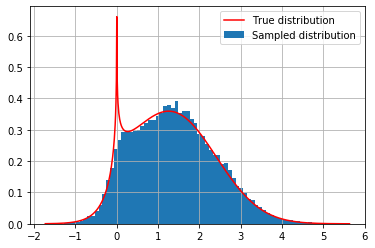

In [979]:
plt.grid(True)
sample_data = np.concatenate(store_horseshoe)
_ = plt.hist(sample_data, bins=80, density=True, label="Sampled distribution")
grid_x = np.arange(min(sample_data), max(sample_data), 0.01)
grid_y = np.exp(
    logdist(x=grid_x, fx=fx, gx=gx_horseshoe, a=a, var=var, tau=tau)) / integration_horseshoe(a, var, tau, fx)
plt.plot(grid_x, grid_y, color="red", label="True distribution")
plt.legend()
# plt.xlim((-2, 2))
plt.savefig("TW_horseshoe_sampled_1d_tau2.png", bbox_inches="tight")

#### Bayesian sparse linear regression
Y = Ax + eps, x with prior

In [1417]:
class laplace_fns():
    def __init__(self, rho, lam, *args, **kwargs):
        self.rho = rho
        self.lam = lam

    def gx(self, x, rho=None, *args, **kwargs):
        if rho is None:
            rho = self.rho
        return rho*np.abs(x)

    def fun_postmean(self, x, lam=None, rho=None, *args, **kwargs):
        if lam is None:
            lam = self.lam
        if rho is None:
            rho = self.rho
#         A = np.exp(-rho*x)*self.approx_norm_cdf(np.sqrt(1/lam)*(x-lam*rho), low=True)
#         B = np.exp(rho*x)*self.approx_norm_cdf(np.sqrt(1/lam)*(x+lam*rho), low=False)
        A = np.exp(-rho*x)*norm.cdf(np.sqrt(1/lam)*(x-lam*rho))
        B = np.exp(rho*x)*(1-norm.cdf(np.sqrt(1/lam)*(x+lam*rho)))
        return x - lam*rho*(A-B)/(A+B)
    
    def approx_norm_cdf(self, x, low=True):
        if low:
            if x > 10:
                return 1
            elif x < -10:
                return np.exp(-x**2/2)
            else:
                return norm.cdf(x)
        else:
            if x > 10:
                return np.exp(-x**2/2)
            elif x < -10:
                return 1
            else:
                return 1-norm.cdf(x)
        return y

In [1418]:
class horseshoe_fns():
    def __init__(self, tau, lam, *args, **kwargs):
        self.tau = tau
        self.lam = lam

    def pi_fn(self, u, tau=None, *args, **kwargs):
        if tau is None:
            tau = self.tau
        return u**(-1/2)*(1+u/(tau**2))**(-1)*(tau**(-1))

    def gx(self, x, tau=None, *args, **kwargs):
        if tau is None:
            tau = self.tau
        if np.isscalar(x):
            x_list = [x]
        else:
            x_list = x
        e_gx = []
        for x_ in x_list:
            ans, _ = quad(lambda u: np.exp(-x_**2/(2*u))*u**(-1/2)*pi_fn(u, tau=tau), 0, np.infty)
            e_gx.append(ans)
        gx = -np.log(np.array(e_gx))
        if np.isscalar(x):
            return gx[0]
        else:
            return gx

    def temp_fn(self, u, x, lam, tau, *args, **kwargs):
        return (lam+u)**(-3/2)*np.exp(-(x**2)/(2*(u+lam)))*self.pi_fn(u, tau)

    def fun_postmean(self, x, lam=None, tau=None, *args, **kwargs):
        if tau is None:
            tau = self.tau
        if lam is None:
            lam = self.lam
        if np.isscalar(x):
            x_list = [x]
        else:
            x_list = x
        res = []
        for x_ in x_list:
            A, _ = quad(lambda u:self.temp_fn(u, x_, lam, tau)*u, 0, np.infty)
            B, _ = quad(lambda u:self.temp_fn(u, x_, lam, tau)*(lam+u), 0, np.infty)
            res.append(A / B * x_)
        if np.isscalar(x):
            return res[0]
        else:
            return np.array(res)

In [1679]:
class bayes_sparse_linear():
    @auto_init_args
    def __init__(self, n, num_iter, h, lam, mtd, s=10, A=None, x0=None, y=None, snr=10, view_num=2000, *args, **kwargs):
        if A is None:
            self.A = self.generate_design(n)
        self.AA = np.dot(self.A.T, self.A)
        self.x = np.array([0] * s + [snr*np.sqrt(2*np.log(n)/n)] * (n - s))
        if y is None:
            self.y = self.generate_y(self.A, self.x)
        self.Ay = np.dot(self.A.T, self.y)
        if x0 is None:
            self.x0 = (np.dot(np.linalg.inv(self.AA), self.Ay)).reshape(-1)
        if mtd == "laplace":
            model = laplace_fns(rho=self.rho, lam=self.lam)
        else:
            model = horseshoe_fns(tau=self.tau, lam=self.lam)
        self.store, self.error_list = self.TDLMC(
            x0=self.x0, num_iter=num_iter, h=h, lam=lam,
            fun_postmean=model.fun_postmean, gradf=self.gradf)

    def generate_design(self, size):
        A = np.random.normal(size=(size, size))
        return A

    def generate_y(self, A, x):
        size = len(x)
        y = np.dot(A, x) + np.random.normal(size=size)
        return y

    def gradf(self, x, *args, **kwargs):
        return np.dot(self.AA, x) - self.Ay

    def TDLMC(self, x0, num_iter, h, lam, fun_postmean, gradf, view_num=None, *args, **kwargs):
        if view_num is None:
            view_num = self.view_num
        store, error_list = [], []
        cur_x = np.array(x0)
        dim = len(cur_x)
        for i in range(num_iter):
            xi = np.random.normal(loc=0, scale=1, size=dim)
            post_mean = fun_postmean(cur_x)
            next_x = (1-h/lam)*cur_x - h*gradf(cur_x) + h/lam*post_mean + np.sqrt(2*h)*xi
            cur_x = next_x
            store.append(cur_x)
            error_list.append(((cur_x - self.x)**2).sum())
            if i % view_num == 0:
                print("iteration " + str(i) + " finished!")
                print("error: " + str(error_list[-1]))
                print(cur_x[0])
        return store, error_list

In [1680]:
# Moreau-Yosida 
class moreau_fns():
    def __init__(self, lam, rho):
        self.lam = lam
        self.rho = rho

    def fun_postmode(self, x, lam=None, rho=None, *args, **kwargs):        
        if lam is None:
            lam = self.lam
        if rho is None:
            rho = self.rho
        y = np.zeros(shape=len(x))
        y[np.where(x > lam*rho)] = x[np.where(x > lam*rho)] - rho*lam
        y[np.where(x < -lam*rho)] = x[np.where(x < -lam*rho)] + rho*lam
        return y

In [1681]:
#laplace
n = 100
s = 10
# rho = 2 * n/np.log(n)
rho = np.sqrt(2*n*np.log(n))
lam = 0.0001
h = lam
num_iter = 4000
snr = 10
print(rho, tau, lam, 10*np.sqrt(2*np.log(n)/n))

30.348542587702926 0.01 0.0001 3.0348542587702925


In [1718]:
np.random.seed(0)
true_x = np.array([0] * s + [snr*np.sqrt(2*np.log(n)/n)] * (n - s))
A100 = np.random.normal(size=(n, n))
y100 = np.dot(A100, true_x) + np.random.normal(size=n)
# pickle.dump([A100, y100], open("A_y_save.pkl", "wb+"))

In [1719]:
td_laplace = {}

In [1720]:
for h in [0.0001, 0.0005, 0.001, 0.005]:
    td_laplace["h" + str(h)] = []
    for i in range(4):
        x0=np.random.normal(size=n)
        laplace_reg = bayes_sparse_linear(
            x0=x0, 
            A=A100, y=y100,
            num_iter=num_iter, h=h, mtd="laplace", lam=0.005, snr=snr,
            n=n, s=s,
            rho=rho, view_num=4000)
        td_laplace["h" + str(h)].append(laplace_reg.error_list)

iteration 0 finished!
error: 891.9707880992543
0.6564852340273132
iteration 0 finished!
error: 836.8684623356968
-0.6561521742724542
iteration 0 finished!
error: 761.3832445006036
0.724855030306784
iteration 0 finished!
error: 996.6148570094507
-0.7606865840169317
iteration 0 finished!
error: 838.5044914282815
-0.06475350693069014
iteration 0 finished!
error: 919.172510812247
-0.44303645946832826
iteration 0 finished!
error: 852.3382367568252
-1.087780347540375
iteration 0 finished!
error: 765.4487195517241
1.2686849641791142
iteration 0 finished!
error: 728.7922969069203
-0.23199118778724268
iteration 0 finished!
error: 765.2087407779348
-1.0570106663308585
iteration 0 finished!
error: 768.438819213333
-0.9923152110591882
iteration 0 finished!
error: 838.447628424528
0.4937637741112871
iteration 0 finished!
error: 466.3863683483982
-0.6814682525979779
iteration 0 finished!
error: 448.14626847181006
-0.5761247336977722
iteration 0 finished!
error: 461.3532015095651
-1.575949750987761
i

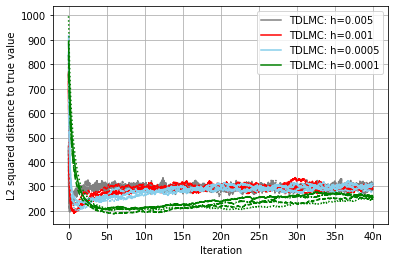

In [1725]:
line_choices=['-', '--', '-.', ':']
color_list = ["grey", "red", "skyblue", "green"]
h_list = [0.005, 0.001, 0.0005, 0.0001]
for h_idx in range(4):
    plt.plot(td_laplace["h" + str(h_list[h_idx])][0], linestyle=line_choices[0], color=color_list[h_idx], label="TDLMC: h="+str(h_list[h_idx]))
    for i in range(1, 4):
        plt.plot(td_laplace["h" + str(h_list[h_idx])][i], linestyle=line_choices[i], color=color_list[h_idx])

plt.grid(True)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("L2 squared distance to true value")
plt.xticks([500*i for i in range(9)], [0] + [str(5*i)+"n" for i in range(1,9)])
# plt.savefig("TDLMC_laplace.png", bbox_inches="tight", dpi=100)



In [1722]:
my_laplace = {}

In [1723]:
for h in [0.0001, 0.0005, 0.001, 0.005]:
    model_my = moreau_fns(lam=h, rho=rho)
    my_laplace["h" + str(h)] = []
    for i in range(4):
        store_my, error_my = laplace_reg.TDLMC(
            x0=np.random.normal(size=n), A=A100, y=y100,
            num_iter=4000, 
            h=h, lam=h, fun_postmean=model_my.fun_postmode, 
            gradf=laplace_reg.gradf, rho=rho, view_num=4000
        )
        my_laplace["h" + str(h)].append(error_my)

iteration 0 finished!
error: 871.2638935992095
-0.17787111791259774
iteration 0 finished!
error: 814.8607127258974
-0.3918742232729262
iteration 0 finished!
error: 894.9302198855734
1.2586363685344728
iteration 0 finished!
error: 867.9705538057029
-0.08659746418483123
iteration 0 finished!
error: 895.9440039823826
-2.018143583224221
iteration 0 finished!
error: 819.6586207565022
0.17175798080174629
iteration 0 finished!
error: 889.2326294945514
0.5810094791055795
iteration 0 finished!
error: 833.5921216722143
-0.1501798869062292
iteration 0 finished!
error: 852.7456482138374
0.32611921711727215
iteration 0 finished!
error: 673.6986851559799
1.1186349983876964
iteration 0 finished!
error: 726.1586316886863
1.229272271769362
iteration 0 finished!
error: 744.6921360628351
-0.06827207547448494
iteration 0 finished!
error: 452.2935485199479
0.6106260889115648
iteration 0 finished!
error: 434.3817516977375
-1.3110580015622921
iteration 0 finished!
error: 448.09495623248057
0.1552669469260664

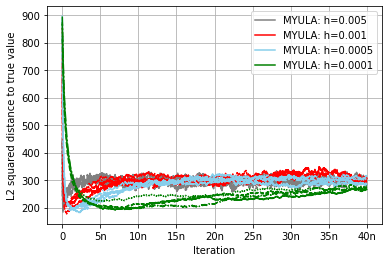

In [1726]:
line_choices=['-', '--', '-.', ':']
color_list = ["grey", "red", "skyblue", "green"]
h_list = [0.005, 0.001, 0.0005, 0.0001]
for h_idx in range(4):
    plt.plot(my_laplace["h" + str(h_list[h_idx])][0], linestyle=line_choices[0], color=color_list[h_idx], label="MYULA: h="+str(h_list[h_idx]))
    for i in range(1, 4):
        plt.plot(my_laplace["h" + str(h_list[h_idx])][i], linestyle=line_choices[i], color=color_list[h_idx])

plt.grid(True)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("L2 squared distance to true value")
plt.xticks([500*i for i in range(9)], [0] + [str(5*i)+"n" for i in range(1,9)])
# plt.savefig("MYULA_laplace.png", bbox_inches="tight", dpi=100)



In [1629]:
#horseshoe

n = 100
s = 10
tau = (s / n) / np.sqrt(n)
lam = 0.001
# lam = 0.01 * np.sqrt(tau)
h = lam
num_iter = 100
print(rho, tau, lam, 10*np.sqrt(2*np.log(n)/n))

30.348542587702926 0.01 0.001 3.0348542587702925


In [1630]:
horseshoe_reg = bayes_sparse_linear(
    x0=np.random.normal(size=n),
    num_iter=num_iter, h=h, mtd="horseshoe", lam=lam,
    A=A100, y=y100, 
    n=n, s=10,
    tau=tau)

iteration 0 finished!
error: 891.9772542259733
-0.12233090797505726


In [1756]:
# h_list = [5e-5, 0.0001, 0.0005, 0.001, 0.005]
# line_choices=['-', '--', '-.', ':', '.']
# color_list = ["grey", "red", "skyblue", "green", "purple"]
# for h_idx in range(5):
#     [_, _, _, error_list, _] = pickle.load(open("res/seed"+str(h_idx*4)+"_niter8000h" + str(h_list[h_idx]) + ".pkl", "rb"))
#     plt.plot(error_list, linestyle=line_choices[0], color=color_list[h_idx], label="MYULA: h="+str(h_list[h_idx]))
#     for i in range(1, 4):
#         [_, _, _, error_list, _] = pickle.load(open("res/seed"+str(h_idx*4+i)+"_niter8000h" + str(h_list[h_idx]) + ".pkl", "rb"))
#         plt.plot(error_list, linestyle=line_choices[i], color=color_list[h_idx])

# plt.grid(True)
# plt.legend()
# plt.xlabel("Iteration")
# plt.ylabel("L2 squared distance to true value")
# # plt.ylim((0, 300))
# # plt.xticks([500*i for i in range(9)], [0] + [str(5*i)+"n" for i in range(1,9)])
# # plt.savefig("MYULA_laplace.png", bbox_inches="tight", dpi=100)


([<matplotlib.axis.XTick at 0x1ac20a58d0>,
 <a list of 11 Text xticklabel objects>)

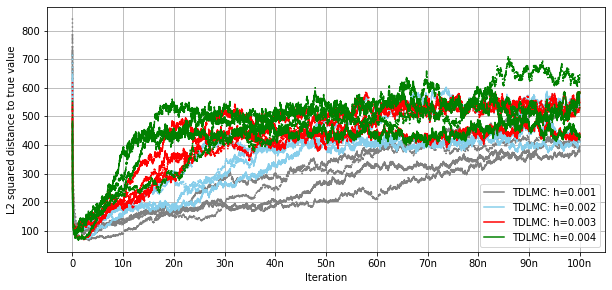

In [1755]:
def name_fn(h, seed):
    return "res_new/seed" + str(seed) + "_niter10000h" + str(h) + "_x0random.pkl"
# h_list = [5e-5, 0.0001, 0.0005, 0.001, 0.003, 0.005]
plt.figure(figsize=(10,4.5))
h_list = [0.001, 0.002, 0.003, 0.004]
line_choices=['-', '--', '-.', ':', '.', '+']
color_list = ["grey", "skyblue", "red", "green"]

for h_idx in range(4):
    [_, _, _, error_list, _, _] = pickle.load(open(name_fn(h_list[h_idx], 0), "rb"))
    plt.plot(error_list, linestyle=line_choices[0], color=color_list[h_idx], label="TDLMC: h="+str(h_list[h_idx]))
    for i in range(1, 4):
        [_, _, _, error_list, _, _] = pickle.load(open(name_fn(h_list[h_idx], i), "rb"))
        plt.plot(error_list, linestyle=line_choices[i], color=color_list[h_idx])

plt.grid(True)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("L2 squared distance to true value")
# plt.ylim((0, 300))
plt.xticks([1000*i for i in range(11)], [0] + [str(10*i)+"n" for i in range(1,11)])
# plt.savefig("TDLMC_horseshoe.png", bbox_inches="tight", dpi=100)
